In [1]:
import torch
import deepsensor
import deepsensor.torch
from deepsensor.train import set_gpu_default_device
set_gpu_default_device()

In [2]:
from deepsensor.train import Trainer
from deepsensor.model import ConvNP
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepsensor.data import DataProcessor, TaskLoader
from tqdm import tqdm
from scipy.special import sph_harm

In [3]:
# Set the path to your Zarr store on GCS
# data_path = '/nfs/turbo/seas-dannes/urop-2024-bias/cfs-forecasts/cfs_precip_2012-2023.zarr'

data_path = 'gs://great-lakes-osd/cfs-data/precip/'

# Open the Zarr store using Xarray
ds0 = xr.open_zarr(data_path, consolidated=True)

# Check the contents of the dataset
ds0

<xarray.Dataset> Size: 44GB
Dimensions:       (time: 16828, lead: 10, latitude: 181, longitude: 360)
Coordinates:
  * latitude      (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * lead          (lead) int64 80B 0 1 2 3 4 5 6 7 8 9
  * longitude     (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
Data variables:
    APCP_surface  (time, lead, latitude, longitude) float32 44GB dask.array<chunksize=(1, 5, 91, 180), meta=np.ndarray>

In [4]:
ds = ds0.isel(lead=0, drop=True)
ds = ds.sortby("time")
ds

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 16828, latitude: 181, longitude: 360)
Coordinates:
  * latitude      (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude     (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
Data variables:
    APCP_surface  (time, latitude, longitude) float32 4GB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>

In [5]:
amplitude = 5

In [6]:
# Apply bias correction function

def random_noise_bias(data, scale=20):
    return data + np.random.uniform(-scale, scale, data.shape)

def gaussian_blob_bias(data, x_center=180, y_center=90, sigma=20, amplitude=amplitude):
    lon = np.linspace(0, 360, data.shape[2])
    lat = np.linspace(-90, 90, data.shape[1])
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    blob = amplitude * np.exp(-((lon_grid - x_center) ** 2 + (lat_grid - y_center) ** 2) / (2 * sigma ** 2))
    return blob[None, :, :]

In [7]:
data_processor = DataProcessor(x1_name="latitude", x2_name="longitude")
_ = data_processor(ds.sel(time=slice("2012-01-01T00:00:00.000000000", "2012-01-31T00:00:00.000000000")))
ds_processed = data_processor(ds)
print(data_processor)

DataProcessor with normalisation params:
{'APCP_surface': {'method': 'mean_std',
                  'params': {'mean': 0.6259567141532898,
                             'std': 0.8941748142242432}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (-90.0, 269.0), 'name': 'latitude'},
            'x2': {'map': (0.0, 359.0), 'name': 'longitude'}}}


In [8]:
print(ds_processed)

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 16828, x1: 181, x2: 360)
Coordinates:
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
  * x1            (x1) float64 1kB 0.0 0.002786 0.005571 ... 0.4986 0.5014
  * x2            (x2) float64 3kB 0.0 0.002786 0.005571 ... 0.9944 0.9972 1.0
Data variables:
    APCP_surface  (time, x1, x2) float32 4GB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>


In [9]:
train_range = ("2012-01-01", "2014-12-31")
val_range = ("2015-01-01", "2015-12-31")

In [10]:
def add_bias_function(data, bias_function, **kwargs):
    return data + bias_function(data, **kwargs)

# Define TaskLoader
biased_contexts = [
    add_bias_function(ds_processed["APCP_surface"], random_noise_bias),
]

task_loader = TaskLoader(
    context=biased_contexts,  
    target=ds_processed["APCP_surface"],
)

print(task_loader)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('APCP_surface',),)
Target variable IDs: (('APCP_surface',),)


In [11]:
import time
import sys
def gen_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates):
        date = np.datetime64(date)  # Ensure consistent datetime format
        try:
            task = task_loader(date, context_sampling="all", target_sampling="all")  
            tasks.append(task)
        except KeyError:
            print(f"Skipping date {date} as it is not found in dataset.")
        sys.stdout.flush()
    print(f"Finished generating {len(tasks)} tasks.")
    return tasks


# Define the ConvNP model
model = ConvNP(data_processor, task_loader, dim_yc=(1,))

# Train the model
trainer = Trainer(model)

dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 359
encoder_scales inferred from TaskLoader: [np.float32(0.0013927576)]
decoder_scale inferred from TaskLoader: 0.002785515320334262


In [12]:
# ds["time"] = pd.to_datetime(ds["time"].values).strftime("%Y-%m-%d %H:%M:%S")

In [13]:
print(ds.time)

<xarray.DataArray 'time' (time: 16828)> Size: 135kB
array(['2012-01-01T00:00:00.000000000', '2012-01-01T06:00:00.000000000',
       '2012-01-01T12:00:00.000000000', ..., '2024-01-01T06:00:00.000000000',
       '2024-01-01T12:00:00.000000000', '2024-01-01T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00


In [14]:
losses = []
val_rmses = []
train_rmses = []

In [15]:
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [16]:
def compute_train_rmse(model, train_tasks):
    errors = []
    context_var_ID = task_loader.context_var_IDs[0][0]  # assume 1st target set and 1D
    for task in train_tasks:
        mean = data_processor.map_array(model.mean(task), context_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], context_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [17]:
print(ds_processed.time.min().values)
print(ds_processed.time.max().values)

2012-01-01T00:00:00.000000000
2024-01-01T18:00:00.000000000


In [18]:
val_dates = pd.date_range(val_range[0], val_range[1])
val_tasks = gen_tasks(val_dates)
_ = model(val_tasks[0])
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

100%|██████████| 365/365 [03:53<00:00,  1.56it/s]
/opt/conda/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


Finished generating 365 tasks.
Model has 1,027,844 parameters


In [19]:
# Train model
#deepsensor_folder = "/home/whruiray/deepsensor_config/"

val_rmse_best = np.inf
train_rmse_best = np.inf

trainer = Trainer(model, lr=5e-5)
train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1]), progress=False)

  5%|▌         | 60/1096 [00:39<11:29,  1.50it/s]

Skipping date 2012-03-01T00:00:00.000000 as it is not found in dataset.


 16%|█▌        | 176/1096 [01:53<10:38,  1.44it/s]

Skipping date 2012-06-25T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-26T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-27T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-28T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-29T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-30T00:00:00.000000 as it is not found in dataset.


 19%|█▉        | 206/1096 [02:09<09:27,  1.57it/s]

Skipping date 2012-07-25T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-26T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-27T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-28T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-29T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-30T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-31T00:00:00.000000 as it is not found in dataset.


 20%|█▉        | 217/1096 [02:11<05:30,  2.66it/s]

Skipping date 2012-08-05T00:00:00.000000 as it is not found in dataset.


 25%|██▌       | 277/1096 [02:49<08:36,  1.59it/s]

Skipping date 2012-10-04T00:00:00.000000 as it is not found in dataset.


 30%|███       | 334/1096 [03:26<08:11,  1.55it/s]

Skipping date 2012-11-30T00:00:00.000000 as it is not found in dataset.


 49%|████▊     | 533/1096 [05:32<05:48,  1.62it/s]

Skipping date 2013-06-17T00:00:00.000000 as it is not found in dataset.
Skipping date 2013-06-18T00:00:00.000000 as it is not found in dataset.


 80%|████████  | 882/1096 [09:15<02:20,  1.52it/s]

Skipping date 2014-06-01T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-02T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-03T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-04T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-05T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-06T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-07T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-08T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-09T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-10T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-11T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-12T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-13T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-14T00:00:00.000000 as it is not found in d

 98%|█████████▊| 1069/1096 [11:01<00:18,  1.50it/s]

Skipping date 2014-12-05T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-12-06T00:00:00.000000 as it is not found in dataset.


100%|██████████| 1096/1096 [11:18<00:00,  1.61it/s]

Finished generating 1045 tasks.


In [20]:
for epoch in tqdm(range(20)):
    #train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1]), progress=False)
    
    print(f"Training batch for Epoch {epoch+1} started...")
    sys.stdout.flush()
    
    batch_losses = trainer(train_tasks)
    
    
    losses.append(np.mean(batch_losses))
    print(f"Training batch for Epoch {epoch+1} complete...")
    sys.stdout.flush()
   
    train_rmses.append(compute_train_rmse(model, train_tasks))
    print(f"Epoch {epoch+1} - Loss: {losses[-1]:.4f}, Validation RMSE: {train_rmses[-1]:.4f}")
    print(f"Epoch {epoch+1} completed in {time.time()} seconds.")
    sys.stdout.flush()
    if train_rmses[-1] < train_rmse_best:
        train_rmse_best = train_rmses[-1]

    val_rmses.append(compute_val_rmse(model, val_tasks))
    print(f"Epoch {epoch+1} - Loss: {losses[-1]:.4f}, Validation RMSE: {val_rmses[-1]:.4f}")
    print(f"Epoch {epoch+1} completed in {time.time()} seconds.")
    sys.stdout.flush()
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]

        #model.save(deepsensor_folder)

  0%|          | 0/20 [00:00<?, ?it/s]

Training batch for Epoch 1 started...
Training batch for Epoch 1 complete...
Epoch 1 - Loss: 0.4550, Validation RMSE: 0.4714
Epoch 1 completed in 1744666468.572704 seconds.
Epoch 1 - Loss: 0.4550, Validation RMSE: 0.4755
Epoch 1 completed in 1744666500.1353815 seconds.


  5%|▌         | 1/20 [08:50<2:48:00, 530.54s/it]

Training batch for Epoch 2 started...
Training batch for Epoch 2 complete...
Epoch 2 - Loss: 0.3314, Validation RMSE: 0.4535
Epoch 2 completed in 1744666996.4581945 seconds.
Epoch 2 - Loss: 0.3314, Validation RMSE: 0.4554
Epoch 2 completed in 1744667028.0671854 seconds.


 10%|█         | 2/20 [17:38<2:38:42, 529.00s/it]

Training batch for Epoch 3 started...
Training batch for Epoch 3 complete...
Epoch 3 - Loss: 0.2911, Validation RMSE: 0.4512
Epoch 3 completed in 1744667524.1676486 seconds.
Epoch 3 - Loss: 0.2911, Validation RMSE: 0.4525
Epoch 3 completed in 1744667555.614836 seconds.


 15%|█▌        | 3/20 [26:26<2:29:41, 528.34s/it]

Training batch for Epoch 4 started...
Training batch for Epoch 4 complete...
Epoch 4 - Loss: 0.2546, Validation RMSE: 0.4304
Epoch 4 completed in 1744668050.9120657 seconds.
Epoch 4 - Loss: 0.2546, Validation RMSE: 0.4323
Epoch 4 completed in 1744668082.364277 seconds.


 20%|██        | 4/20 [35:12<2:20:43, 527.71s/it]

Training batch for Epoch 5 started...
Training batch for Epoch 5 complete...
Epoch 5 - Loss: 0.2174, Validation RMSE: 0.4195
Epoch 5 completed in 1744668578.06614 seconds.
Epoch 5 - Loss: 0.2174, Validation RMSE: 0.4220
Epoch 5 completed in 1744668609.625033 seconds.


 25%|██▌       | 5/20 [44:00<2:11:53, 527.55s/it]

Training batch for Epoch 6 started...
Training batch for Epoch 6 complete...
Epoch 6 - Loss: 0.1818, Validation RMSE: 0.4039
Epoch 6 completed in 1744669103.9566596 seconds.
Epoch 6 - Loss: 0.1818, Validation RMSE: 0.4056
Epoch 6 completed in 1744669134.3682632 seconds.


 30%|███       | 6/20 [52:44<2:02:52, 526.59s/it]

Training batch for Epoch 7 started...
Training batch for Epoch 7 complete...
Epoch 7 - Loss: 0.1544, Validation RMSE: 0.3952
Epoch 7 completed in 1744669620.281745 seconds.
Epoch 7 - Loss: 0.1544, Validation RMSE: 0.3968
Epoch 7 completed in 1744669650.821504 seconds.


 35%|███▌      | 7/20 [1:01:21<1:53:22, 523.28s/it]

Training batch for Epoch 8 started...
Training batch for Epoch 8 complete...
Epoch 8 - Loss: 0.1292, Validation RMSE: 0.4007
Epoch 8 completed in 1744670145.2860193 seconds.
Epoch 8 - Loss: 0.1292, Validation RMSE: 0.4026
Epoch 8 completed in 1744670176.5303652 seconds.


 40%|████      | 8/20 [1:10:06<1:44:48, 524.05s/it]

Training batch for Epoch 9 started...
Training batch for Epoch 9 complete...
Epoch 9 - Loss: 0.1070, Validation RMSE: 0.3822
Epoch 9 completed in 1744670670.4786024 seconds.
Epoch 9 - Loss: 0.1070, Validation RMSE: 0.3840
Epoch 9 completed in 1744670701.5183892 seconds.


 45%|████▌     | 9/20 [1:18:51<1:36:07, 524.35s/it]

Training batch for Epoch 10 started...
Training batch for Epoch 10 complete...
Epoch 10 - Loss: 0.0936, Validation RMSE: 0.3806
Epoch 10 completed in 1744671194.533257 seconds.
Epoch 10 - Loss: 0.0936, Validation RMSE: 0.3826
Epoch 10 completed in 1744671225.7338057 seconds.


 50%|█████     | 10/20 [1:27:36<1:27:23, 524.31s/it]

Training batch for Epoch 11 started...
Training batch for Epoch 11 complete...
Epoch 11 - Loss: 0.0776, Validation RMSE: 0.3729
Epoch 11 completed in 1744671718.8040357 seconds.
Epoch 11 - Loss: 0.0776, Validation RMSE: 0.3746
Epoch 11 completed in 1744671749.7284563 seconds.


 55%|█████▌    | 11/20 [1:36:20<1:18:37, 524.21s/it]

Training batch for Epoch 12 started...
Training batch for Epoch 12 complete...
Epoch 12 - Loss: 0.0632, Validation RMSE: 0.3708
Epoch 12 completed in 1744672241.6821358 seconds.
Epoch 12 - Loss: 0.0632, Validation RMSE: 0.3726
Epoch 12 completed in 1744672272.7280147 seconds.


 60%|██████    | 12/20 [1:45:03<1:09:50, 523.84s/it]

Training batch for Epoch 13 started...
Training batch for Epoch 13 complete...
Epoch 13 - Loss: 0.0524, Validation RMSE: 0.3725
Epoch 13 completed in 1744672765.005902 seconds.
Epoch 13 - Loss: 0.0524, Validation RMSE: 0.3750
Epoch 13 completed in 1744672796.1119626 seconds.


 65%|██████▌   | 13/20 [1:53:46<1:01:05, 523.70s/it]

Training batch for Epoch 14 started...
Training batch for Epoch 14 complete...
Epoch 14 - Loss: 0.0397, Validation RMSE: 0.3687
Epoch 14 completed in 1744673288.3386784 seconds.
Epoch 14 - Loss: 0.0397, Validation RMSE: 0.3709
Epoch 14 completed in 1744673319.3424366 seconds.


 70%|███████   | 14/20 [2:02:29<52:21, 523.56s/it]  

Training batch for Epoch 15 started...
Training batch for Epoch 15 complete...
Epoch 15 - Loss: 0.0309, Validation RMSE: 0.3635
Epoch 15 completed in 1744673810.4081943 seconds.
Epoch 15 - Loss: 0.0309, Validation RMSE: 0.3656
Epoch 15 completed in 1744673841.4676392 seconds.


 75%|███████▌  | 15/20 [2:11:11<43:35, 523.13s/it]

Training batch for Epoch 16 started...
Training batch for Epoch 16 complete...
Epoch 16 - Loss: 0.0203, Validation RMSE: 0.3661
Epoch 16 completed in 1744674333.7558556 seconds.
Epoch 16 - Loss: 0.0203, Validation RMSE: 0.3685
Epoch 16 completed in 1744674364.70883 seconds.


 80%|████████  | 16/20 [2:19:55<34:52, 523.16s/it]

Training batch for Epoch 17 started...
Training batch for Epoch 17 complete...
Epoch 17 - Loss: 0.0120, Validation RMSE: 0.3610
Epoch 17 completed in 1744674856.9611368 seconds.
Epoch 17 - Loss: 0.0120, Validation RMSE: 0.3630
Epoch 17 completed in 1744674888.0451632 seconds.


 85%|████████▌ | 17/20 [2:28:38<26:09, 523.21s/it]

Training batch for Epoch 18 started...
Training batch for Epoch 18 complete...
Epoch 18 - Loss: 0.0059, Validation RMSE: 0.3633
Epoch 18 completed in 1744675380.7929351 seconds.
Epoch 18 - Loss: 0.0059, Validation RMSE: 0.3654
Epoch 18 completed in 1744675411.8212895 seconds.


 90%|█████████ | 18/20 [2:37:22<17:26, 523.38s/it]

Training batch for Epoch 19 started...
Training batch for Epoch 19 complete...
Epoch 19 - Loss: -0.0002, Validation RMSE: 0.3604
Epoch 19 completed in 1744675904.6493163 seconds.
Epoch 19 - Loss: -0.0002, Validation RMSE: 0.3630
Epoch 19 completed in 1744675935.8768518 seconds.


 95%|█████████▌| 19/20 [2:46:06<08:43, 523.59s/it]

Training batch for Epoch 20 started...
Training batch for Epoch 20 complete...
Epoch 20 - Loss: -0.0120, Validation RMSE: 0.3608
Epoch 20 completed in 1744676428.1888006 seconds.
Epoch 20 - Loss: -0.0120, Validation RMSE: 0.3631
Epoch 20 completed in 1744676459.1669173 seconds.


100%|██████████| 20/20 [2:54:49<00:00, 524.48s/it]


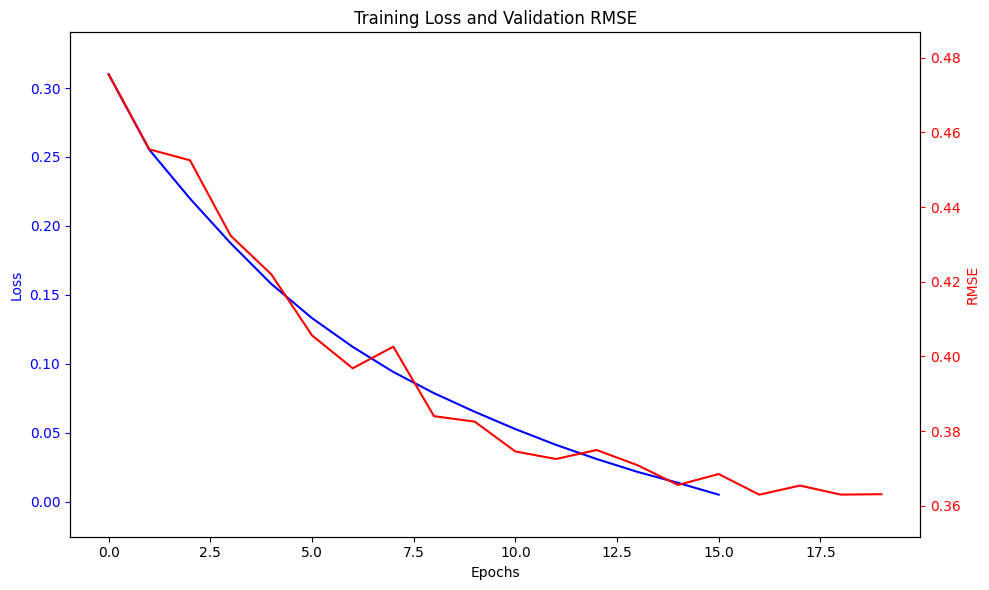

In [21]:
import os
import matplotlib.pyplot as plt

# Plot training metrics with adjusted scales
fig, ax1 = plt.subplots(figsize=(10, 6))

# Smooth the loss values (using simple moving average)
window_size = 5
smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

# Plot training loss
ax1.plot(range(len(smoothed_losses)), smoothed_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis for validation RMSE
ax2 = ax1.twinx()
ax2.plot(range(len(val_rmses)), val_rmses, 'r-', label='Validation RMSE')
ax2.set_ylabel('RMSE', color='r')
ax2.tick_params('y', colors='r')

# Adjust scales to show downward trend
if len(losses) > 0:
    loss_min, loss_max = min(smoothed_losses), max(smoothed_losses)
    ax1.set_ylim(loss_min - 0.1*(loss_max-loss_min), loss_max + 0.1*(loss_max-loss_min))

if len(val_rmses) > 0:
    rmse_min, rmse_max = min(val_rmses), max(val_rmses)
    ax2.set_ylim(rmse_min - 0.1*(rmse_max-rmse_min), rmse_max + 0.1*(rmse_max-rmse_min))

plt.title('Training Loss and Validation RMSE')
fig.tight_layout()
plt.show()
fig.savefig("fig/random_noise_Loss_and_RMSE.png")


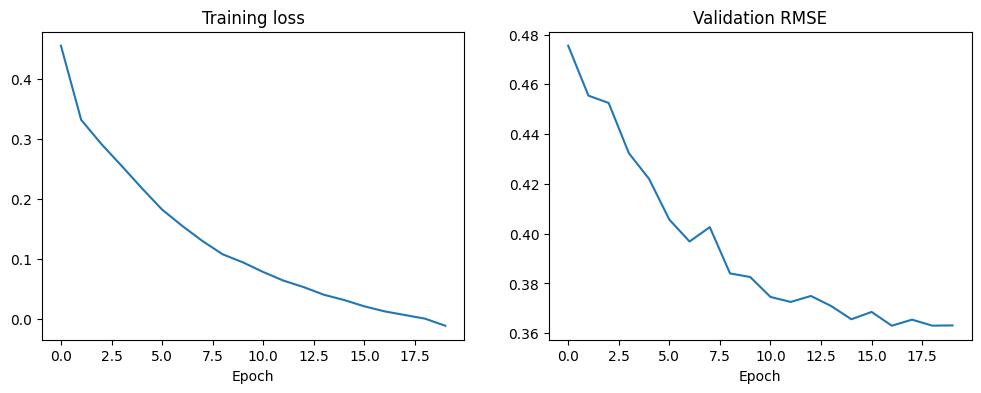

In [22]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")

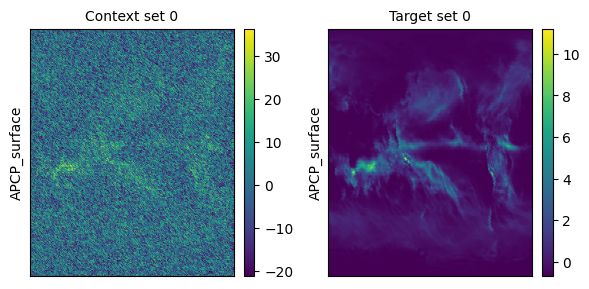

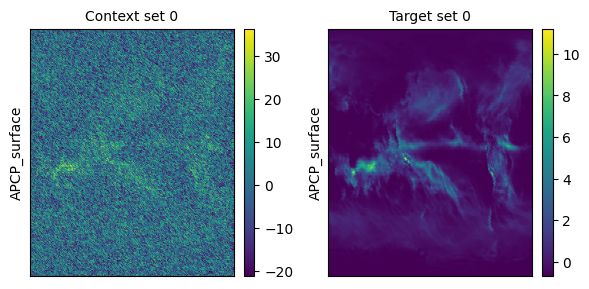

In [23]:
import deepsensor
from deepsensor import plot
import matplotlib.pyplot as plt

# Select a sample date for visualization
sample_date = "2012-01-01"
sample_task = task_loader(sample_date, context_sampling="all", target_sampling="all")

task_loader_random_noise = TaskLoader(
    context=biased_contexts,
    target=ds_processed["APCP_surface"],
)
# Plot context (biased) and target (original) data
deepsensor.plot.task(sample_task, task_loader=task_loader_random_noise)

/var/tmp/ipykernel_1454462/1852109447.py:53: UserWarning: rename 'x1' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  }).rename({
/var/tmp/ipykernel_1454462/1852109447.py:53: UserWarning: rename 'x2' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  }).rename({


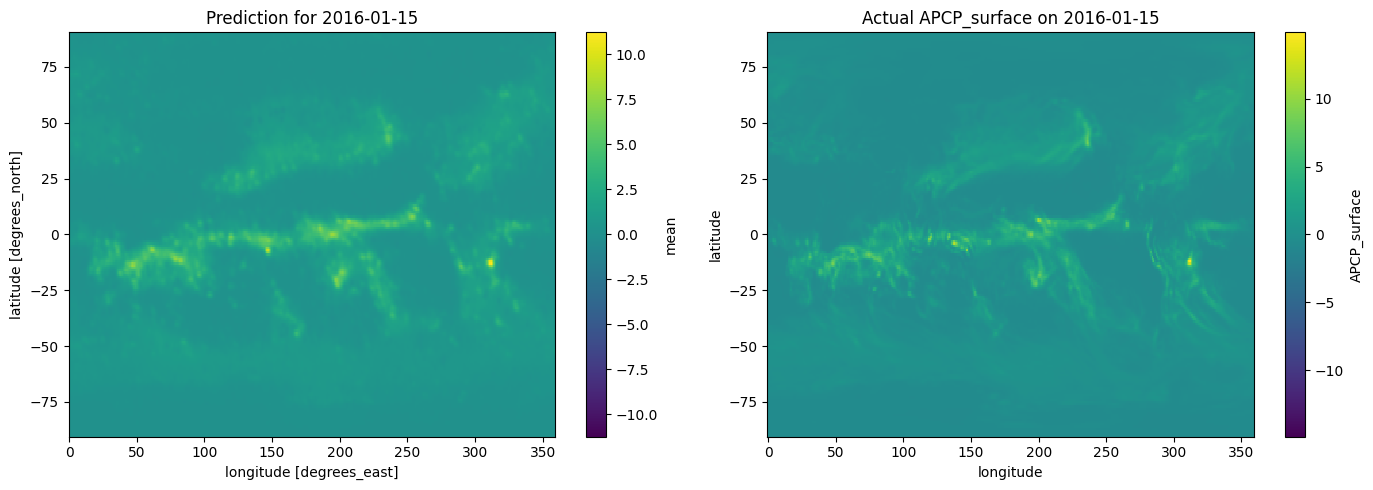

In [27]:
# import matplotlib.pyplot as plt

# target_date = "2016-01-15"
# target_timestamp = "2016-01-15T00:00:00.000000000"

# # Step 1: Predict
# task = task_loader(target_date, context_sampling="all", target_sampling="all")
# pred_val = model.predict(task, X_t=ds)
# predxr = pred_val["APCP_surface"]

# # Step 2: Actual data
# actual_apcp = ds_processed["APCP_surface"].sel(time=target_timestamp)

# # Step 3: Create side-by-side subplots
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # Plot 1: Predicted Mean
# predxr['mean'].plot(ax=axes[0], cmap='viridis')
# axes[0].set_title(f"Prediction for {target_date}")

# # Plot 2: Actual
# actual_apcp.plot(ax=axes[1], cmap='viridis')
# axes[1].set_title(f"Actual APCP_surface on {target_date}")

# plt.tight_layout()
# plt.savefig(f"prediction_vs_actual_{target_date}.png")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

target_date = "2016-01-15"
target_timestamp = "2016-01-15T00:00:00.000000000"

# Step 1: Predict
task = task_loader(target_date, context_sampling="all", target_sampling="all")
pred_val = model.predict(task, X_t=ds)
predxr = pred_val["APCP_surface"]

# Step 2: Actual data
actual_apcp = ds_processed["APCP_surface"].sel(time=target_timestamp)

# Step 3: Re-map coordinates from x1/x2 → latitude/longitude
lat = np.linspace(-90, 90, actual_apcp.sizes['x1'])
lon = np.linspace(0, 359, actual_apcp.sizes['x2'])

actual_apcp = actual_apcp.assign_coords({
    'x1': lat,
    'x2': lon
}).swap_dims({
    'x1': 'latitude',
    'x2': 'longitude'
}).rename({
    'x1': 'latitude',
    'x2': 'longitude'
})

# Step 4: Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Prediction
predxr['mean'].plot(ax=axes[0], cmap='viridis')
axes[0].set_title(f"Prediction for {target_date}")

# Plot 2: Actual (now with lat/lon axes)
actual_apcp.plot(ax=axes[1], cmap='viridis')
axes[1].set_title(f"Actual APCP_surface on {target_date}")

plt.tight_layout()
plt.savefig(f"fig/random_noise_prediction_vs_actual_{target_date}.png")
plt.show()

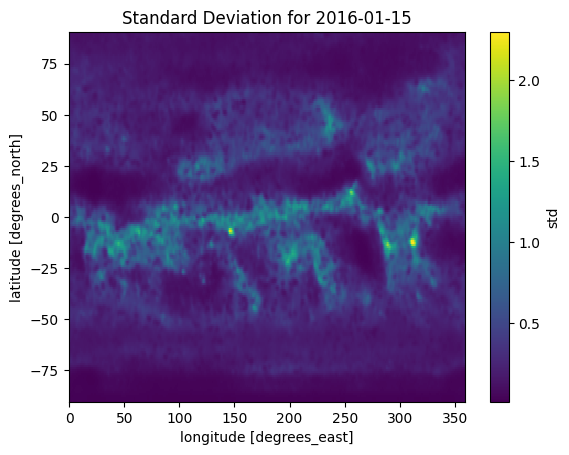

In [28]:
predxr['std'].plot(cmap='viridis')  # Plot standard deviation
plt.title(f"Standard Deviation for {target_date}")
plt.savefig(f"fig/prediction_for_random_noise_{target_date}_std.png")

In [ ]:
pred_val